# Jagermeister Project


**Import modules**

In [40]:
from sklearn.datasets import load_files  
import numpy as np
import pandas as pd
from keras.utils import np_utils
import cv2

import keras, os
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, Flatten, MaxPooling2D, MaxPool2D, AveragePooling2D, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import preprocess_input
from tensorflow.keras.constraints import max_norm
from numpy import expand_dims
from io import BytesIO
from PIL import Image
from tabulate import tabulate

import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

**Mount Drive and unzip images into Colab**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive') # gdrive sync

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!unzip 'gdrive/MyDrive/Brainster Jager Project/receipts.zip' -d content/ #personal path

Archive:  gdrive/MyDrive/Brainster Jager Project/receipts.zip
replace content/receipts/test/receipts_0/1548.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
!rm content/receipts/train/receipts_0/image_captions.csv

rm: cannot remove 'content/receipts/train/receipts_0/image_captions.csv': No such file or directory


# Read files and preprocess the images

**Create functions for image processing**

In [5]:
def load_image(path):
  image = cv2.imread(path).astype('float32')
  image = preprocess_input(cv2.resize(image, dsize=(331,331)))
  return image

def image_process(files):
  vector = []
  for file in files:
    vector.append(load_image(file))
  return np.array(vector)

**Load Train and Validation datasets**

In [6]:
def load_dataset(path):
    data = load_files(path)
    color_files = np.array(data['filenames'])
    color_targets = np_utils.to_categorical(np.array(data['target']), 3)
    color_names = data['target_names']
    return color_files, color_targets, color_names

# load whole dataset
train_files, train_targets, train_names = load_dataset('content/receipts/train')
val_files, val_targets, val_names = load_dataset('content/receipts/test')

In [7]:
print(tabulate([['Train', len(train_files), train_targets.shape, len(train_names)],
                ['Validation', len(val_files), val_targets.shape, len(val_names)], 
                ], headers=['Dataset', 'No. of files', 'Target shape', 'No. of classes']))

Dataset       No. of files  Target shape      No. of classes
----------  --------------  --------------  ----------------
Train                 3590  (3590, 3)                      3
Validation             957  (957, 3)                       3


**Preprocess the images**

In [8]:
#train dataset
train_X = image_process(train_files)
train_X.shape

(3590, 331, 331, 3)

In [9]:
#validation dataset
val_X = image_process(val_files)
val_X.shape

(957, 331, 331, 3)

## Visualize the train dataset

In [10]:
class_names_processed = list(map(lambda x : x, train_names))

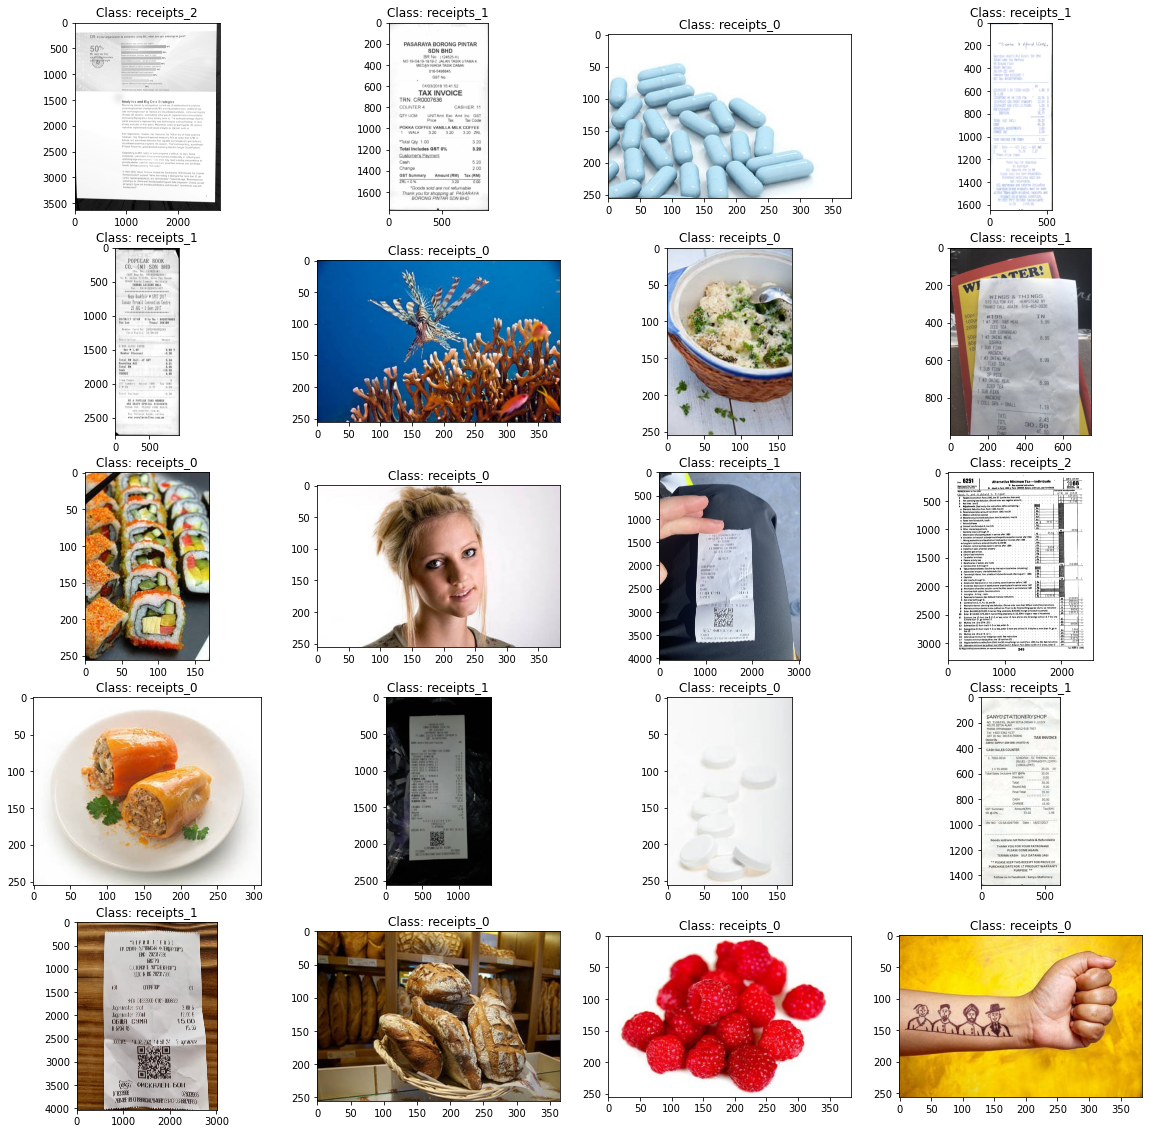

In [11]:
# add graph
fig = plt.figure(figsize=(20,20))

rows = 5
columns = 4

for i in range(rows*columns):
    ax1 = fig.add_subplot(rows, columns,(i+1)) 
    # show the image
    image = cv2.imread(train_files[i])
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax1.imshow(img_rgb, cmap='gray')

    title = "Class: "+class_names_processed[np.argmax(train_targets[i])]
    plt.title(title)

## Generator

In [12]:
def generator(X_samples, Y_samples, batch_size=50):
    """
    Lazy batch train/validation generator for memory efficiency
    """
    while True:
      for offset in range(0, len(X_samples), batch_size):
        batch_samplesX = X_samples[offset:offset+batch_size]
        batch_samplesY = Y_samples[offset:offset+batch_size]
        new_batch = []
        for image in batch_samplesX:
          image_resized = cv2.resize(image, dsize=(150,150))
          new_batch.append(image_resized)
        X_train = np.array(new_batch)
        y_train = batch_samplesY
        yield X_train, y_train
train_generator = generator(train_X, train_targets, batch_size=10)
test_generator =  generator(val_X, val_targets, batch_size=10)

# Model Architecture

## NasNetLarge model

In [13]:
from keras.applications import NASNetLarge
model = NASNetLarge(
    input_shape=(331,331,3),
    weights="imagenet",
    include_top=False
)

layer = model.get_layer('normal_conv_1_12')

layer_1 = Dense(64, activation='relu')(layer.output)
pool1 = GlobalAveragePooling2D()(layer_1)
drop1 = Dropout(0.4)(pool1)
layer_2 = Dense(32, activation='relu')(drop1) # Added another layer with average
# pool2 = GlobalAveragePooling2D()(layer_2)
layer_3 = Dense(16, activation='relu')(layer_2)
# pool3 = GlobalAveragePooling2D()(layer_3)
layer_4 = Dense(8, activation='relu')(layer_3)
batch_norm = BatchNormalization()(layer_4)
drop2 = Dropout(0.4)(batch_norm)
output = Dense(3, activation='sigmoid')(drop2)

model = Model(inputs = model.inputs, outputs = output)

In [36]:
model.layers[300]

In [52]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_16[0][0]                   
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_3900 (Activation)    (None, 165, 165, 96) 0           stem_bn1[0][0]                   
___________________________________________________________________________________________

## VGG16

In [ ]:
# from keras.applications import VGG16

# model = VGG16(include_top=False, input_shape = (150,150,3), weights='imagenet')

# layer_1 = Dense(256, activation='relu')(model.output)
# pool = GlobalAveragePooling2D()(layer_1)
# layer_2 = Dense(128, activation='relu')(model.output) # Added another layer with average
# pool = GlobalAveragePooling2D()(layer_2)
# layer_3 = Dense(64, activation='relu')(model.output)
# pool = GlobalAveragePooling2D()(layer_3)
# layer_4 = Dense(16, activation='relu')(pool)
# batch_norm = BatchNormalization()(layer_4)
# drop = Dropout(0.4)(batch_norm)
# output = Dense(3, activation='sigmoid')(drop)

# model = Model(inputs = model.inputs, outputs = output)

In [ ]:
# model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0  

## Define Loss Function, Optimizer

In [14]:
optimizer = keras.optimizers.Adamax(lr=0.0005) # changed the lr from 0.0005
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

## Define Augmentation

In [15]:
datagen = ImageDataGenerator(
      rescale=1./255,
      #rotation_range=10, # ISKLUCENO ZARADI TOA STO E MNOGU SPORO
      #width_shift_range=0.01,# ISKLUCENO ZARADI TOA STO E MNOGU SPORO
      #height_shift_range=0.01,# ISKLUCENO ZARADI TOA STO E MNOGU SPORO
      #shear_range=0.01,# ISKLUCENO ZARADI TOA STO E MNOGU SPORO
      #zoom_range=0.01,# ISKLUCENO ZARADI TOA STO E MNOGU SPORO
      #horizontal_flip=True,# ISKLUCENO ZARADI TOA STO E MNOGU SPORO
      fill_mode='nearest')

datagen.fit(train_X)

## Train the model

In [16]:
from __future__ import generator_stop
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-5)
checkpoint = ModelCheckpoint('best_model.pt', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# model fit code
history = model.fit(datagen.flow(train_X, train_targets),
          validation_data = test_generator,
          steps_per_epoch = len(train_X)/50,
          validation_steps = len(val_X)/50,
          epochs=30, #added 5 epochs more
          callbacks=[anne,checkpoint],
          batch_size = 100)

Epoch 1/30


ResourceExhaustedError: ignored

## Load best model

In [ ]:
from keras.models import load_model

best_model = load_model('best_model.pt')

* Save best model to zip

In [ ]:
!zip -r content/best_model.zip  best_model.pt

  adding: best_model.pt/ (stored 0%)
  adding: best_model.pt/assets/ (stored 0%)
  adding: best_model.pt/saved_model.pb (deflated 90%)
  adding: best_model.pt/variables/ (stored 0%)
  adding: best_model.pt/variables/variables.index (deflated 75%)
  adding: best_model.pt/variables/variables.data-00000-of-00001 (deflated 7%)


# Model Evaluation

In [ ]:
# validation dataset

score = best_model.evaluate(val_X, val_targets)

print('Test accuracy: ', score[1]*100,'%')

33/33 [==============================] - 3s 73ms/step - loss: 0.1409 - accuracy: 0.9549
Test accuracy:  95.49376964569092 %


## Confusion Matrix

In [ ]:
# Predicted values for validation dataset

predictions = best_model.predict(val_X)
val_predictions = np.argmax(predictions, axis=-1)

In [ ]:
# True values for validation dataset

val_targets_class = np.argmax(val_targets, axis=-1)

## Precision and Recall

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

#print evaluation metrics 
print(classification_report(val_targets_class,val_predictions))
confusion_matrix(val_targets_class,val_predictions)
print("Accuracy:",accuracy_score(val_targets_class,val_predictions))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       452
           1       0.98      0.99      0.98       391
           2       0.93      0.85      0.89       200

    accuracy                           0.95      1043
   macro avg       0.95      0.94      0.94      1043
weighted avg       0.95      0.95      0.95      1043

Accuracy: 0.9549376797698945


## Visualize Model Training History

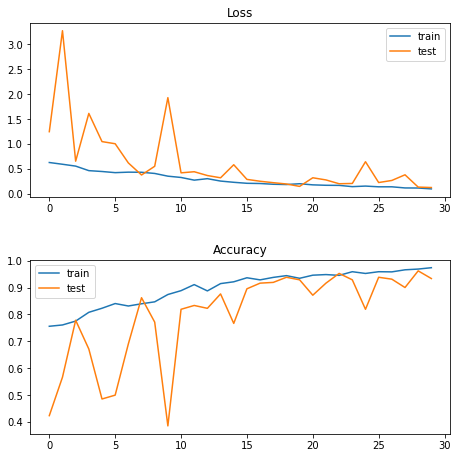

In [ ]:
figure, axes = plt.subplots(nrows=2, ncols=1,figsize=(7,7))
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
figure.tight_layout(pad=3.0)
plt.show()

# Predictions

 **Define functions for prediction**

In [21]:
def get_prediction(image):
    image = np.expand_dims(image, axis=0)
    prediction = best_model.predict(image)
    predicted_class = np.argmax(prediction)
    return class_names_processed[predicted_class]

In [22]:
class_names_processed = ['receipts_0', 'receipts_1', 'receipts_2']

In [23]:
import urllib.request

def url_to_image_(url):
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image_ = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image_resized = preprocess_input(cv2.resize(image, dsize=(224,224)))
  return image_resized, image_

def predict_url(url):
  image_resized, image = url_to_image_(url)
  predicted_class = get_prediction(image_resized)
  plt.imshow(image)
  plt.title("Predicted : " + predicted_class)

In [24]:
def predict_url_test(url):
  image_resized, image = url_to_image_(url)
  predicted_class = get_prediction(image_resized)
  if predicted_class == 'receipts_0':
    return 'Not Valid'
  elif predicted_class == 'receipts_1':
    text = detectText_from_url(url)
    words = text.lower().split()
    return words
  else:
    text = detectText_from_url(url)
    words = text.lower().split()
    return words

### Loading model from google drive

In [18]:
!unzip 'gdrive/MyDrive/Brainster Jager Project/best_model.zip' -d content/ 

Archive:  gdrive/MyDrive/Brainster Jager Project/best_model.zip
   creating: content/best_model.pt/
   creating: content/best_model.pt/variables/
  inflating: content/best_model.pt/variables/variables.data-00000-of-00001  
  inflating: content/best_model.pt/variables/variables.index  
   creating: content/best_model.pt/assets/
  inflating: content/best_model.pt/saved_model.pb  


In [19]:
from keras.models import load_model

best_model = load_model('content/best_model.pt')

In [34]:
text = predict_url_test('https://www.redsun.bg/wp-content/uploads/2016/11/Mesechna-smetka-za-tok-27.02.2016-izdadena-ot-CEZ-Bulgaria.jpg?x70005')

In [35]:
text

['фактура',
 'оригинал',
 'ne',
 '0183453017',
 '/',
 '27.02.2016',
 'доставчик:',
 'чез',
 'електро',
 'българия',
 'ад',
 'адрес:',
 'бул.',
 'цариградско',
 'шосе',
 '159,',
 '1784',
 'софия',
 'идснтификационен',
 'ne:',
 '175133827',
 'зддсn:',
 'bg175133827',
 'банк.с/ка',
 'сitibgsf',
 'вg62cti925011111сezel',
 'банк.е/ка',
 'ingbbgsf',
 'bg97ingb914511111cezel',
 'жк.',
 'хади',
 'софия',
 'п.код',
 '1510',
 '6000000005612462',
 'получател:',
 'име:',
 'адрес:',
 'ж.к.',
 'хаджидимитьрыософия',
 'клиентски',
 'номер',
 ':',
 '300061088715',
 'за',
 'обект:',
 'софия,',
 'ж.к.',
 'хаджи',
 'димитър',
 'консумирана',
 'електрическа',
 'енергия',
 'от',
 '18.01.2016',
 'до',
 '17.02.2016',
 'електромер',
 'na',
 '1450860852',
 'дневна',
 'нощна',
 'общо:',
 'показания',
 'старо',
 '8',
 '563',
 '1',
 '738',
 'kbty',
 'показания',
 'ново',
 '8',
 '868',
 'разлика',
 'корекция',
 '305',
 '305',
 '1814',
 '76',
 '76',
 '381',
 'снабдяване',
 'с',
 'електрическа',
 'енергия',
 'от',
 

In [ ]:
for word in text:
  if 'факт' in word:
    print('postoi faktura')

postoi faktura


In [41]:

img = image.load_img('slika1.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)


In [42]:
np.argmax(best_model.predict(x).round())

1

In [52]:
text1=detectText_direct_img('slika1.jpg')

In [50]:
text2=detectText_direct_img('slika2.jpg')

In [53]:
lista2 = text2.lower().split('\n')

In [54]:
lista1 = text1.lower().split('\n')

In [56]:
lista2

['"p mbepa 0 2" e0oa',
 'с. равница общ. мадан',
 '66p30 xpahehe',
 'k.k. mamnopobo aapo ctyrehel',
 '300c n bg 203061569',
 '#301',
 'onepatop1',
 'lo',
 '00',
 '22.006',
 '22.00',
 '22.00',
 'егермайстер',
 'в брой лв',
 '0031283 26.02.2021 17:06:27 1 aptmkyn',
 '1 артикул',
 'bg фискален бон',
 '02518806',
 'dt518806',
 'fd36449c366674cc08f 2825acad8d2810b207bcf',
 '']

In [55]:
lista1

['el"edmt-c. nenesahoba-b. macypcka"',
 'c. uimpoka jibka ya "k. ii. bombona" 57',
 'ейк: 830120611',
 'чаина връх сне жанка',
 'k. k. iiamnopobo bpdx chexahka',
 '3aac n bg 830120611',
 '#01',
 'onepatop1',
 '01',
 '4 x',
 '5.00',
 'met epmamctep 50',
 'обща сума',
 'в брой лв',
 '20.00 6',
 '20.00',
 '20. 00',
 '0004364 13.02.2021.11:36:03 1 aprmkyn',
 'bс фискален бон',
 'di768061',
 '5e7f247h66862c9334bf 5882b661f85£b50a548e',
 '02768061',
 '']

In [ ]:
jager_dict = {
    0: 'егермайстер',
    1: 'иегермаистер',
    2: 'jeger'
}

In [ ]:
vlatko = 'vlatko'

for key,value in jager_dict.items():
  if vlatko == value:
    print('vlatko')

vlatko


In [ ]:
mat=re.match('(\d{2})[/.-](\d{2})[/.-](\d{4})$', datestring)

In [ ]:
import re
for word in lista:
  mat=re.match('(\d{2})[/.-](\d{2})[/.-](\d{4})$', word)
  if mat:
    print(word)

## Testing

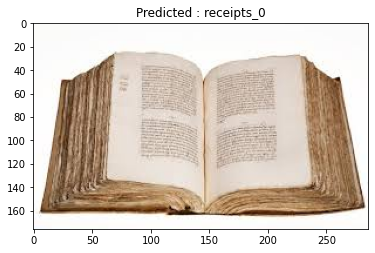

In [ ]:
predict_url('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTLNDhMFFH8PW9NWSC_KjqGvjprR70gF7K2uQ&usqp=CAU')

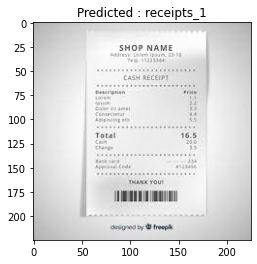

In [ ]:
predict_url('data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBESERERERERERERERIREREPERIRERIQGBQZGRgYGBgcIy4lHR4rHxgYJjgmKy8xNTU4HCU7QDs0Py40NTEBDAwMDw8QEBERHjcdFh00NDQxMT8xMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMf/AABEIAOEA4QMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAACAwABBAUGB//EAEIQAAICAQIDBQYCBwYEBwAAAAECABEDEiEEIjEFE0FRYSMycYGRsRRyBjNCUqGywWJzgrO00TRjdIMVJCVTVHXw/8QAFQEBAQAAAAAAAAAAAAAAAAAAAAH/xAAVEQEBAAAAAAAAAAAAAAAAAAAAEf/aAAwDAQACEQMRAD8A9UqxqrIqxirApVjVWRVjFWBQWGFlhYwLAELDCwkXcfETX3Q326wMYWEFmsYR5S+6HlAyhZemahhEIYR5QMmmTTNnciQYh5QMemTTNowjy6y+5XbbpAwaYJWdIYF326y/w67bdIHLKwSs6/4dbJrrt6SfhUqq8bvx+sDjFYJWd38KmrVpHSq8PpB/BJpK1sTd3zfWBwSsArN3aCBcmlQAAi7D4mZSsDOyxbLNLLFssDOyxTLNLLFssBGmSM0yQHqsYokVYxVgRVjFWRVjVWBSrDCy1EMLAiruPjNoWZUXcfETeqwKVYQSEqwwICwkuh6efyjKnmOK7Kytm41kwjTn4fKmvIcRZshRVQY2B1KhA3VtgQCIHo9IkFVdivO9p5rJ2LxGjiVZjl7xeCoOca94uJy2TEdIAAK8tnrqgP2HkfGyDEmFH45cy4HGPImHEMWhiVB0m2BbSD+18YHqak2+nWcntDsnVwScIup1X8PjYuwDNjTImok+elSZzP8Awni3xZsORUY5uKx68jsCuThceJF1sqkG37sKV/tHwgepkseY+s8rn7N4wjhHVVPEcNgyYS5dQGLOmPV16FQXrzUDrAHYmRE4JBi1pw+TiSwB4dyFbLeNqybe6LJHMPjA9fJKLStUA7kuK1yd5A5XaB/8wR/y0/maJZYfGNfE/wDbX7tLZYGdli2WaWWKZYGdli2WaGEWywE6ZIVSQNCiMUQVEaogEohqJSiMUQLUQgJFEYBAijcfGbRMjDb5j7zXAIGFcAS7gYh2dWmsj8uoi/3mBs7V1LE/7Ql4GgoGRwFBFWwB5Ao6Hwq/mfjNdyiYGLG6ozK2RrJVBqFAsVHu7+NX85XDY1bcZSdIQEAFRtVbX/Z+/wABrfGp3Kgm7ut7qvtFJiRCSqgEkkkQMmNVUK3eZW0Jrs6t1Vzdgnr4EeUHKBrbnddRZAAp2ezkPjXQivhv5TW+NCKKqR5Eet/feLOJP3R1LdP2j1PxgZHy42G+bJvpZa1AjvKCDY7kVfzmzPj1lSWXlDj3LBLCr62Nr2ijhx/uJ4D3R4bj6Qi0AWwLoVdR5UKAkA7FQPpyg1GY30qq37oAv4CKLQSYDzmgHNEEwCYC3e+IB/5YH8TNbCYE/Xr+X/edEiAlhFsI9hFsICGEWwj2EUwgK0yQqkgPURiiCojVEC1EYolKIxRAtRGASlENRAFxt8x9xNMz5fd+a/cTQYCX4e9fPkGsAcrVoodU8jLbDZY63GpAlBtl68w8m36xtyXAUuGip1vypootsenMf7W3WAMQQIS71jUgl32YV1c+M0RHFYi6gAgEMjDULW1awCNrG0Ba41AQ94xCE5NRyA6la/ePiu5r4Qe6UgVkcg5NYIe7vmC3+76eUVk4As7OXBLoEKlaTSKIqiGFMCeviZE4GmR2dmZShJ3AYqjJut1fNdwJkRPaA5WHOrtzgHH0of2Qa6esHMqHXeUrrQHZwNCjbUvl16wM/Z2psjB6LlTuDS06NtRBF6N/l5bzJwRIddS0+lr0tqDqEHvarrk+O/WATqps94RrQYxTgCzZBX+0bgoqkgq5bQndkBwwvbdgP2tusB+zwx5zY1WyixfswlXd14x+PHpLn99y/SuoA/pAUmCu753OhSvM1678W8zBHD1o53Ohi27e9d7N5jfp6TSYJgZjw+1a3/Wa71b9b0/l9IZhmCYGZB7dfh/vOownOxj26/l/3nUYQEMIthHsIthAzsIthHsIthAVUkKpIDVEaogKI1RAJRGKIKiMUQLURgEpRDUQF8R7vzX+YR8RxXuf4l/mEfAxBsT95pzHnIRtOStDKDsnkdj9ITHGSzd77+NV2yCgDdMovqd9/GpgOHhbU92zNrdxTliHBaxu3xNdBY6WJMacNjAC4slIxWrJAZEKXRb91iPkPSBu7zENLd77qHHRydeXVZHUvpUnz6y0VAcY7wkpaAHICXahsw/aYRCdjYBr5SdZJNu2w0MmkUeml2Hzhr2ZhDahj3195epjT6laxv5qDX+8Bq8MAEGtzoZmFuSWu9m8xv0+Eo8MKrW/v671m7u9P5fSPMEwM78MDrGvINbh9nI0kVsvkNunqYOThwdfNkGsAHS5Gmh+z5TQZRgZ3wAljqfmTRsxoDfceTb9YPciwdT8qFKLGiNtz5tt1jzBMDOnDhdHM57tSo1OTqvxbzMQ4RCiNkYNqd1D5Db7EkHzAvpNpmfiOEx5DboGOh0s+COAGA8rA6wEUlV3p2c5LOSuhBIv9zcem80GYuI4TCRlLY7NUQHI1gBX2HpX8PWblQAADYAAAeggK4dfbD0WdJhMnCp7QnyQfebWEBTCLYRzCLYQEsIphHsIphAXUqFUuAxRGrFrGLAYsNRBWGsA1EYsFYYgI433B+dP5hHRHaHur+dP5hHwMSvns+4VBAuxvzC9/QE+HgJYPEEqfZgbah1sV4G/P7zP3eMCy7qCzMCQAGCnc7eG9WdzdQsLYUYHvGJJAUNY3awNq67EelekDo3KnPxtiQq2trHu6lO4YORW3kT9B5wceHHae0yM1grdg2Sz9K28fpA6JlGI4bhRj6MzcqqSxs7Fj1/xGOMATKMIyjAAwTDMowFkSiIdSiIGLIX9pXoE58Yrbrv069D5es0AbC/nMmY4/bkuRSqMlAbCjQHr1mxANIrpQr4VAbwa8zH0AmhhFcIN2+Uc0BbRbRjQGgKaJaOaLaAuSXJAYsYsWsYsBqw1gLGLANYwQFhiBm7RPKn51+8eZm7SOyfnX7zQYHNZ3/8AjrevIRag8pGx28T43XSEuUk6hgGzlbreg4GoberHy67zS7ZOfSiGgO7tyNRrfVty/wAZbNktqVSAgKEsbL77HbYdN4GVWIo9wAAAelaRZB8PC/vBx5iUx5MeFdTq9kfsFQQoO2/l9ZrVntbVa0WxDGw+3KNtx13lI2T2epEFg95Tk6WrYLtuL+EC8Ds2rUumjt13G8MxSvkpLRASzB6cnSm9Ebbnpt8ZWvJXuJfeVWs13d+9096vCA0yjFM2TnpEJDgJbkak2snbY+9t6CU7ZPaaUQ0B3duRqat9W238YDZRi3Z7alUgJaW5BL77HbYdN5QOS1tVrRbHUbD7bAVuOu8BkqotDk5NSILU95pcnS3gF23HWCrZKS0QEsQ9OTpTeiNtz02+MBGTV7TkUnbSdDEMK3B8z19Nx6zSo2G1bDby9JWrJXuJeuq1mu7v3unvV4RtQGcMN2+Ua0Vw3VvlHNAU0BoxotoCmimjWi2gLklyQDWMWLWMWA1YxYtYawGrDEBYYgYu0zvj/OPuJqMxdqHmx/mH3E2mBwm7QzY/xTOyOuPPjwpqTukVXXGxd3F8o1kXXhKXtxt3dFRPwmPiQrF+81szAiq90UtnwsE9dugWzbBQCbyaixSgK5dIBG1kdd47h+8tu8qjRWuo62CfHw+sDn9m9pPmfGSuhXwZHKe9Tpm0bN5UCfnOtJcqBDKMsyoAyS5IFSSSQKqcPju0c+McR+r5M2FEbTS48brZZiTRPr0szuwcurS2kEtR0gEA38TtA4vaPabLw2PLjZVb2bZFyBRkCtjL6AhNaztS/GdlDYB33ANEUdx4iZvbU+9nko3jBH73oDXn4+k1oDQutVC66XW8A8A3b5RjQMXVvlCMAGi2htAaApotoxotoASSSQCWMWKUxqwGrGKYpYxYDQYYi1MNTA5/ah58f5h9xNxnO7TPtMfxH3E6JgYjwQ2piCuvSygAjWQTfn08YD8AaULkawUsuSQyqBtt8P4mWz4H7y22clMlsy2UXcDyoeUK8THI2r9gI51MAEqx8Op36/SA/h8WhdOpm3JtzZ3MZcx+yBHMAUQ46LNstAkEefTeFgxJpxsgNInISze6wHW+u3nA0yjEpwqAIADyMXXmY0xu7336nrJ+FSqo1r7z3m9+7vr0vw6QHSRLcKhDgg87h25mHMKqt9ug2lvwqNrsH2gAemYWB0rfb5QG1JUW3DISxINundtzN7m/06neQYEBU+Kp3Y5j7hrar67DeA2pIpOGxrorrjBVOcmgdiDvv08ZE4bGNAH7DM685NMbu99+p2MAH4QMcm/v6QRXTT08etmaFWgB1oVZ6mYycIBB1AB3zb95etG5v4+E3Lvv5wInU/KW0odT8pTQBaLaExgMYC2i2hsYtoA3JKkgWpjVMQpjVMBymNUxCmNUwGqYamKUwwYHN7RPtU+K/cTpmcjjz7ZPiv3E65gch8mMEluHNg5WGxsoALb5g/LeOV1/9kjWQrbHf1O3T1Pr0mjK7jvKQNpA7vnA7wkbj0lPlcFqSwEtTqHM+/L6eG/rAy43QtQwsuvmcsrDq1Gz57Axq8SVAAxtQLqFQNaquwG/Ukb+VQhme1BSgU1MdQ5X25fXx39JEzudF461AnJzg92a2Hr8oE4Ximc0yMm12b0nmIAF79ADNMzJnc6Lx1bEONYOhRdH1uht6yd+9fq99emtY9y/f+nhA1CXMrZnp6x2Q4CjWBqQ1belWdvSE+Vx3lY9WkDRzgazW49IGmVoHWhfnQ//AHgPpEtke2pLATUp1Aan35fTw39Zau9qNFApqY6hyvty+vjv6QKzZCroq49WrWS/QIQLFmvExR4kjpjF+zsaWBBf3h03q+sfjyOdGpNOpSX5we7bwHrLTI5CXjq2IcawdCb03rdDb1gYCwqvw2wVwFYM1DXW4O1Vv9Z1U6ChQoUKqhXSooZHr3N9emtY9y/f+m9TQICz1PwEFjLc8x+A/rAYwKYxTGGximMAWMUxhsYpjAq5cG5UAlMYpiFMYpgaFMNTEqYamA9TDBiVMYpgcrjW9uv5k+4nXdpxOJb24/Ov3E7OSAt3iWeXkiSIFnJLGSZOK4pMY1ZG0jS7WQTyoupjt5CZOI7e4TGqNkyhRkRXQlX3RgSp2HoYGviuLyo/IgddAagG1F9arV3XQk/KZz2rm6Dh2vumYag+nvtTaUJHhpWyfUSHtvhQ2NTlGrKQEGl+YmgPD1EofpDwnd993y93r7vXpetenVXS+m8B/DdpZXfGrYWRHGTU7K3IVd1Cn1IUG+n1EvP2jnQOe6B05HRaGR9YVCy9BY1bKD0Bu72l5e2OGxsivkCtkZUQaW5mYKQOnk6/WXxfbvC4f1mUJuRurncEg9B5qfpAbi47I2Qp3dBcmhmIcbanAIPQ8qIdtuadMGchO3+ELaBmGqga0v0ILDw8gYzJ27wiBC2UAPq0cr81Irnw/dZT84HUBhiYuG7Qw5HKY3DOLJFMOiox6jyyIf8AFNogEIQgiGIGfIec/lX+sBjLynnP5V/rFsYFMYDGRjAYwBYxbGWxi2MCXJAuSBFMapmdTGKYGhTGKYhTDUwHqYxTEKYYaBycze3/AMa/cTvZBPOu3th+df5hPSOsDI4iyI91gFIHm/0qHsz/AHPF/wCSZ4r9JP1PB/8AS8N/I8+ocTwuPIKdFcUy0wsaWFMPmNpmzdicLkCq/D4nCKqIGSwqKCFA9BZgeA4ge37O/vMX8yTCR/6Wf/sD/p59RPY3CkoxwYy2MgoSu6EdK8uglDsHhNHdfhsXd6+80aOXXp06q862geM7d/4jgv8AqsH+Vw0zfpr1H53/AJ8s+h5OyeHcoz4UZkYOhZbKsAoBHqAi/QScT2NwuX9Zgx5N751veyfux+sD5xwv/FH8mL/JeP7V9zgv+9/pcE+gr2LwgbWOHxBqA1Bd6AofwJhv2PwraA2DG3d3otb02oU18lUfKBwf0Z/4vJ+V/wDT8FPXiZcHBYsbF0xojGwWUUTYRfsiD/CJpgHcsGLuXqgIzHnP5V/rFMZeY85/Kv8AWLYwIximMtjAYwKYxTGWxi2MCXJAuSBSmMVpnVo1WgaFMYrTOrRitAerRgaIVoQaByUPtl/vF/mE9U2ZNTLrXUothYtR6zlDCnXSL+EYqL5D6QND5sekNrXSxoG9iZRZbK2NQFkeNRYVfIfSEAPIQKLpWrUKur9ZYIvTYsiwPSEAPIfSFt5CAAdaJsUNifWGGWwLFnp6ybeUvbygQOu+45evpC7xeXcc3u+sAkDrQHrQEs15QC1ruLHL73pJ3qUDqFNsPWAa8oJryEB3eLZFiwLI8hB79KDahpJoHwuKNeUEgeQgPOVdWnUNVXV71APFJpLa10g0Te1+USQPIQCB5D6QDyNbk+BVf6xbNKJgs0CMYtmkZotmgUxi2MtmimMC9UkDVJApWhq0zq0arQNCtDVpnVoxWgaFaMDTOrQlaBoDQw0QGhBoDw0INEBoQaBy1ycdruhpOkHUMZCsCb0gNulHqSG2HrAbi+MXTaHU5CqAivbalBLUaRdJY7eXkDOwGhapUjmNk44MRWNlA2YKltsdW2oUw20+B8fMW7cWq4ypOrTk1l1xso9ralwGvZL929wBOlql6oV539IcPF8RwaMi5A7hjk4bG6430OpKDU37SHQSLF0wgpwnaA4bh9LuM6Pmyuj5O8s92/dI7a+YBtAIuvGek1StUVI89kz9rh2ATA6DKFD6FBbHzU1axsRpvoQbq5jXN2rlGDKuPTWl2ViMWpWVdQbGHpqttOqjYGrTvPWapRaKQYbYf16yi0AtALSKMtALSi0AtAJmgFoJaCWgRmgM0pmi2aBGaLZpGaLZoBapIvVJAixiySQGLDWSSAwQ1lSQGCEJJIBCEJckCCWJJIFiSSSBJJJIFGSSSAJgmSSAJgGXJABoDSSQFtAMkkBbRbSSQAkkkgf/2Q==')

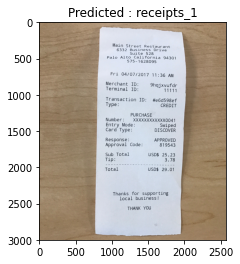

In [ ]:
predict_url('https://discuss.poynt.net/uploads/default/original/2X/6/60c4199364474569561cba359d486e6c69ae8cba.jpeg')

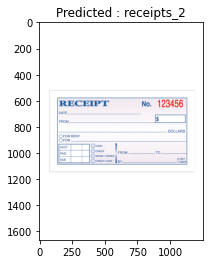

In [ ]:
predict_url('https://media.officedepot.com/image/upload/b_rgb:FFFFFF,c_pad,dpr_1.0,f_auto,h_1665,q_auto,w_1250/c_pad,h_1665,w_1250/v1/products/162370/162370_p?pgw=1&pgwact=1')

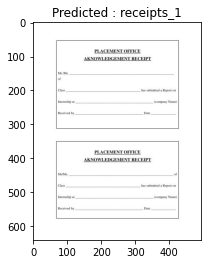

In [ ]:
predict_url('https://img.yumpu.com/34613701/1/500x640/acknowledgement-receipt.jpg')

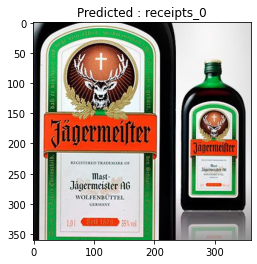

In [ ]:
predict_url('https://www.liquor.com/thmb/6mZHdYIvomni8FuOd-sWPaP7UEk=/360x360/filters:fill(auto,1)/__opt__aboutcom__coeus__resources__content_migration__liquor__2011__12__15163208__jagermeister-liqueur-0c49461931d4416d9f9e9bdd76da2dd6.jpg')

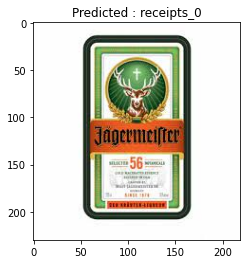

In [ ]:
predict_url('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRq_T_jzfbe0qKJCXIDZ-8dZ1jXpno3UV1dY2AJkmjI1XMus3VLMw6MG6-hYaHRsne8lAs&usqp=CAU')

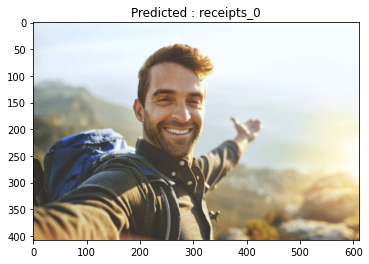

In [ ]:
predict_url('https://media.istockphoto.com/photos/thisis-what-its-all-about-picture-id1155613377?k=6&m=1155613377&s=612x612&w=0&h=qa03hxFs1grJG6n338AR_Nt1Ivp_7ze9GdaYFe_SVDY=')

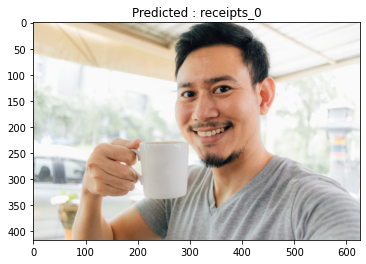

In [ ]:
predict_url('https://image.freepik.com/free-photo/selfie-portrait-happy-man-drink-mug-hot-coffee_39688-2215.jpg')

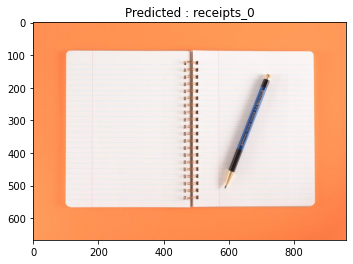

In [ ]:
predict_url('https://cdn.shopify.com/s/files/1/0251/1906/products/hightide_penco_coil_compostion_notebook_inside_960x.jpg?v=1570028475')

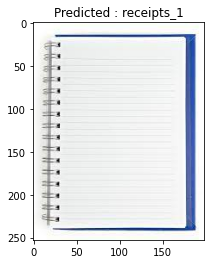

In [ ]:
predict_url('data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBISEBAPEBQRDw8PDw8PDxEPFRURERERGBQZGRgUGBgcIC4lHB4rHxgYJjgmKy8xNTU1GiQ7QDszPy40NTEBDAwMEA8QHBESHTEhIyE1NDQ0NDQxMTU0MTE0MTQ0NDQ0NDQ0NDUxMTQxNDQxNDQ0NDE0NDQxMTQxNDE0MTE0NP/AABEIAP0AxwMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAAAAQIFBgMEB//EAE0QAAECAwQFBwgHBgMHBQAAAAEAAgMEERJhkaEFITFRcQYWIlST0eEHEzJBcoGx0hQzYnOSssIjJDRTdLNCo8EVF0RjgqLwQ1Jkg5T/xAAYAQEBAQEBAAAAAAAAAAAAAAAAAQUEAv/EACYRAQABAwMEAgMBAQAAAAAAAAABAhJRAxGREzNSgTJhITE0cQT/2gAMAwEAAhEDEQA/APsyEJEoGklaCq5nlDJw3uhxJiAyIw0cxz2hzTuI9SREz+kmdlqhUnOvR/W5btG96R5VyHWpftG969WVYk3jK8QqHnZIdZl+0b3oHKyR6zA/G1SyrEm8ZXyFQHldI9Zl+0CXO+Q6zL9oFbKsSl0ZaBCz/O+R6zA/G1PnfIdZgdo1LKsSXRlfoVBzukOswPxhHO+Q6zA7RqWVeMl0ZX6FQc75DrMD8YRzvkOswPxhOnX4yXU5X6FQc75DrMD8YRzw0f1mD+JOnV4yXU5X6Fnzyx0eNszB/Elzz0d1mD+I9ydOvE8F1OWhQs7z00f1iH7rR/0S566P6w33Nef0q9KvE8F1OWjQs5z20d1gdnF+VWGitOS00XiWiCKYYaX0a5tm1WnpAbipOnXTG8xMeiKon8RK0QhC8vRLk9y6lVelXEQwQARaFoOeYbbP23DWB/4VJHQTkO3YcaGlelqGK8c1oeQivMWLAlosR9AXxGse51PVUqlgwS+aYxrZVpsOdrhmIylD6qipvRyg5PzEyIDIboUJsKZgR32C6EyIxjgXNcwA137doC9RMx+vwkxErjm1o7qUp2EPuT5t6O6lJ9hD+VWLna0qq3TmU2jCv5taO6lJ9hD7kc2dHdSlOwh9ysaoql85nk2jCt5s6O6nKdjD7kc19HdSlOxh9ys6oql9WZ5Nowq+a2jepSvZM7kc1NG9TluzarWqKpfVmeTaMKnmro3qct+BqOamjepy/wCAK2qnVOpVmeS2MKjmno3qcv2YT5p6N6pL/gCtqoqnUqzPJtGFSOSujepy3ZtT5q6O6nLdm1WtUVTqVZnldowqxyX0d1OV7JncmOTGjupynYwz/orSqKpfVmeUtjCtHJvR/U5TsIfyodyckCC36JKgOBBswWMNCPU4AEG8a1ZKTNqXVfZtGHwbScsyHEjsbqZCmIkNpNSbLXuaOJ1BbzyUuqyapqFYNB+PWd5vWE5QGsxNf1cf+49bjyS+jN8YP61qa0zP/PMz9OWiNtV9HQkmsl2Iv2LwzccMAJDnFxshrBUk7tdBiV7nqr0jAMRtgOoK9JtSA8biW6x7lJFBBmnfTmuZDe93myPNgww70NtS6zmvbpTlHClRC+kMiQ3R4rYTG9AkvcQBrt09ddRVZKSbTPNhutFoh1Nl72mvm6+kDU4q5ntAy0cMEVrnthRGxYYc60WPaahwcauzVFmQkh2s7Tkil5y7kQ01Gl5yTod6BpqNDvyTod4w8UDTUde8YeKNd2Higkmo694w8Ua7sPFBJCWu7DxRQ3YeKBoS13YeKNd2HigaaWu7DxRQ3YeKCSlD2qAU4e1B8I039fNf1Mc/5jlt/JN6M3xg/rWI0yP281/Uxv7hW58lHozfGD+taur/ADz6ctPdfRAhAQsp1ovVRpSaMMNoWtLjTpC273MDgT7lbRFXzEJr9oNQDQtJa4e8a1JGTl5h30wOt2XFhFpsN0Q+hSlgHVxXXlHp6PKfRBCpHMxMwoMQubZLGOcAXWNvr3heiRaG6Q1agIZH/YtGHj1EYqgc3XtOSKXnJBbxxKLPHEogpecu5Ol5y7kWeOJRZ44lAUvOXcnS85dyLPHEos8cSgKXnLuTpecu5KzxxTs8UBS85dydLzl3JUvKdLygKXnJFLzkizeUWbygKXnJOl5ySs3lOnFAUvOSdLzkizxRZ4oGB71Jm1RAUmbUHwnS3101/URf7hW48lHozXGF+pYbSv1sz9/F/uFbnyUejNcYX6lq6v8APPpy0919ECaELKdblFVBpuE9xZZZbABq40eG/wDQRmr6KqycmWs1EPc5wJAYxzzTeaCgHFSRlpSRc6cslkBxaxxpFaXNHRHq3616OU3JyZmjKeadChNl5mFFiNq4MexrmktaKGh1atSnJzf789wZEf0X6mtBIFBr20VlpLlBAlnQGxxEY6ZiNhQgQ2pe4gAUtV9YVFs8AmqVkbkOArrpW+iBZ+zkiHZCdn/ypS6P2ckUb9nJA7PHEos8cSlRt2SdBdkgdnjiUWeOJSoNwyToNwyQOzxxKLPHEpWRuCdkbggLPHEos8cSiyNwRZFyB2eOJRZ44lFBdkiguyQOzxxKdnjiUqC7JFBdkgkApM2qIp6qe5SZtRXwjSn1sz9/E/uFbryUDoTXtQvg5YbSh/aTH30T+4VuvJT6E17UH4PWprfzz6ctPch9CQhCy3U4xVTaUlDEA6VA2pskChO+u0K4jKk0tNuhloa6E20DUP1vPsttBSRUyGjmmce1z4pstfrbEewmlBtaQrLSXJuXmXQHRvOPMtEZFhVc02XtII6RaXHYK61Syc8fpT3efgMJD6l0Nzq6xqAtghdeUHKOPLRZBkEMjtmZmDBivDCGsa97Gk0rqJDjSp/wqjWOfei0N4Q40PrwKLXHAogtDeE7Q3jFFrjgUWuOBQFRvGSKi7JO1xwKLXHAoFUXZJ1F2SLXHAp2uOBQKrbskVbdkna44FO1xwKCNW3ZJ1F2SdrjgUWuOBQFRdkiouyTtccCna44FAqi7JOouyRa44FO1xwKAFPVT3KTNqiCpM2or4TpL6yY++f/AHFuvJT9XNe1B+D1hdIenH+8f+dbnyU+hN+1B+D1qa388/7Dlp7kPoaEIWW6nCKq+ZhtcDaaHUB2gGmpWEVUWlZZz3AtYHgNNSYpZT/oskFQcNFn99jU1dGJ+Zqvg31099FjZCRiGaiAQZd1lryQ6NEYB0m6xZZrKlp7QUzGmdHxILWw4ctMQYkwGubSI1r2ki242tQDtVnXVUa4m4orcU3HXsOXelW45d6IdbiivFFbjl3orccu9A7XHBFrjgUVuOXeitxy70Ba44FO1xwKVbjl3p1uOSAtccCna44FKtxy7063HLvQFrjgUWuOBRW45d6dbjl3oC1xwKdrjgUq3HJOtxyRRXjgU7XHApVuOSdbjkgAVJm1RBUmbUHwufHTj+2/863Hkq9Ca9qF8HLE6RH7SP8AexPzlbfyWDozXtQv1LU1uxPpy09yH0FCELLdThFVVOzjIZsuDySNVljiPxbM1bRVVTss55JESIwUILWWA04trmoKbRc+BNRiWRjVrxRsJ7iOm3bQalZTmn5aC+DCjOMOJMxGQoLHNNp73uDWizt2uGumqqrtEyNZmOPOxtQd6LwCekNpAXr0jyYgzEeWmYj4pfKxYcaFraRaY5rqG00mhLRWlFRcmt2KNe4Y+CbibsUte4Y+CIevcMfBFTuGKNd2PgjXuGPggdTuzRU7s0te4Y+CevcMfBAVO7NPXuzS17hj4Jit2PggdTuzRU7s0a7sfBGu7HwQFTuzTqd2aNe4Y+CNd2Pgiip3Zp1O7NGu7HwRrux8EBr3Zp1O7NLXdj4J67sfBABSbtUQpN2oPh+kh+1mB/zYv5ytt5LPQmvahfByxekvrpn72N+dy2vktHQmvahfBy1NXsT6c1Pzhv0IQst0uEVUWlZ0w3WREgsq3U2Ix5cTc4GivYq8cQ6juoVBk9D6SLY8YmNKAuqKveQDV41Ab16NL8pI0CZkYDGMiw5uPChPisa8shtc9rTV9qgcQ7VqOxe7QbgZiZ9/51cmAwm2WMLgQQ4tBcCNhrRUScDdglruw8UyDvSod+SIeveMPFGu7DxRQ78kUO/JA9d2Hiihuw8UUO/JFDvyQPXdh4o13YeKVDvyTod+SB67sPFGu7DxRQ78kUO/JA9d2HijXdh4o178kUO/JFPXdh4o13YeKKHfkih35IDXdh4p67sPFKh35J0O/JAwm3akFJu1B8R0n9fNfex/zuW08lvoTPtQvg5YzSg/bzX30f8AO5bTyXehM+1D+DlqavYn05qfnDfIQhZbpcIyodKyZiPBEOE8BtLT3vY8cA0UzV9GVPPz7YZsuZFdUVtMhvewcXAUCkjPaHkneej0hPdZNCGzUVlOkfWHdL3qem9FTkSbkIktbhy8GYl3zLLbHecYIjS8l5eHEBtdVDVejQWk4QjTBc5wtHVVj/8A3G7UruLpeXY+HCfEDYkZ4ZCYQ6r3HYBqVHscNe05JUvOXcmW8cSlZ44lEOl5y7kUvOXcizxxKLPHEoHS85dyKXnJFnjiUWeOKB0vOXcil5y7kWeOKLPHFA6XnLuTpeckrPHFOzxxQFLzkil5yRTjiinHFFOl5yRS85IpxRTigdLzkil5yRTiinFAAKbdqgApt2oPiulR+8TP38f87lsfJd6E17UP4OWP0r/EzQ/58x+dy2Pku+rmvah/By09bsT6c9PzhvUIQsx0OEZU87INiPDi+KwjYGPst42SCFcRlQ6Rm3sfZY+VaKCrYz3tf7gFJHg0HJPMSPZmI7LLhWz5npdI7asXqneTEKNNS0697nRpVzXQna60B9E9KzQ+yq7QE3Fa+OaS3SLal8ZzP8R9HoGq9elOUxgTknKeaMT6XEYwxGV83DtOprd6zdRUaIjjiUWeOJQWjcEWRuGCILPHEp2eOJSsjcME7I3DBAWeOJRZ44lFkbhgiyNwwQOzxxKLPHEosjcMEWRuGCB2eOJTs8cSlZG4YIsjcMEDs8cSizxxKLI3DBFkbhginZ44lFnjiUWRuGCLI3BA7PHEos8cSiyNwRZG4IABTbtUAFNu1B8X0x/Ezf38z+dy1/ku9Ca9qH8HLIaa/iZv+omfzuWu8l31c17UP4OWlq9ifTnp+cN+hJNZrocIy8EWG1xq5rXbPSaD8V74wWd0pLudFBEOM8ANo9kWja6tjLW33KSOXJ2Whl8x0GGjhSrGmms3K4fo+C57YjoMJ0Rjg5jyxpexw2FppUFZbQbHW4tGzh6Q+qcxoGs+lU1XacdpD/aUmIJitkA8/SA5rySLJpadZs2a0/xKjVGnrpkjo/ZyTLhvCVobxiiDo/ZyR0fs5J2hvGKdobxigXR+zkjo/ZyTtDeMUWxvGKBdH7OSfR+zki0N4TtDeEC6P2ck+j9nJO0N4RaG8YoDo/ZyR0fs5J2hvCLQ3jFFLo/ZyT6P2ck7Q3jFFobxigXRuyT6N2SLQ3jFO0N4xQDaeqnuUm7VEFSbtQfGdMj95m/6mZ/O5a7yYehM+1D+DlkdMj95nP6mZ/O9a3yW/VzPtQ/g5aWp2J9Oen5w3wQgIWa6HKMqib0lBhvDHva1/RNk12V27lcRVTzsrEe+rIoY3V0HMttr7nAqSKrk9pCEHRrcRjLTm0tPaK6zs1q+M5CDmMMSGHvNGML2hzzStGgnXq3LOcn5WLWKWvgN6QragOeTwPnNS6TPJbzmkZbSLojQ6WcSWBpAd0C3UAaN2+uqo0hPHAp2uOBSLuOBRa44FEO1xwKdrjgUrXHAotccCgdrjgUWuOBRa44FFrjgUDtccCi1xwKVrjgU7XHAoHa44FFrjgUrXHAp2uOBRTtccCi1xwKVrjgU7XHAoC1xwKdrjgUrXHAp2uOBQFrjgU7XHApWuOBRa44FAwVJu1RBUm7UHxrTX8VO/wBRNfnetb5Lj0Jn2ofwcslpr+Lnaio+kTY20r03rWeS36uZ9qH8HLR1OxPpz0/OG+BQgIWc6HKKqPSE7EhvDWMa9pskEPYHm6y5zf8AVXkUqpnJeXLw6KIdt1AC4hr3eqm2pUkUnJmciAxQJeK8FwqWuggN42njJe2b5TwYU7L6Pe1/n5lxa0NoQzo2qv8AUNW4leTkxIQonni5pdYeLPTfqrX1VuVy/Q0AxYccseYkF1uGTEiFrXUpWzapsuVHtJuOSK3HLvQTcckVuOSIdbjl3orccu9FbjkitxyQOtxyRW45d6VbjknW74ICtxyTrccu9Kp3fBOt3wQFbjl3p1uOXelW74J1u+CKK3HJOtxySrd8E63fBAVuOSK3HJFbvgit3wQOtxyRW45JVu+CdbjkgYKk3aogpt2oPjmm/wCLnP6iY/O5avyXehM+1D+Dlk9Pfxk4P/kzH53LV+Sv6qZ9uH8HLR1OxPpz0/OPbfhCAhZzocogVFPysXzrns84Wua0UgvY1xoKa2PFkm+oWgc1cXsUGJ5OviMESjplgc8Vsy4jDZ6yzYu0XTU2NKSsqwNdKPc4R3uY0PAEN5HR9JnSbSpWi0dKCAx9pws1tFzuiGgDWSSdi7f7Rgfz4PaM71YiTd0NbsfBLXuGPguf06B/Og9ozvUTpGWG2Ylxxis71dpwjtr3DHwT17hj4LzHS0oNsxLDjGh96gdNSQ2zUqP/AL4fzJtODeHs17hj4J69wx8F4Tp6S63KdvC+ZR5wyHXJP/8ARC+ZW2TeMrDXuGPgjXuGPgq7nHIddk+3hfMjnJo/rkn28P5ktq+03jKy13Y+CNd2Pgqw8pdH9clO2h96R5UaO65K9qzvSyrE8F0ZWuvcMfBGu7HwVTzp0d1uW7RqOdOjuty3aNSyrxngupyttd2PgjXuGPgqvnRo7rkr2rO9McptH9cle1Z3pZV4zwXU5WmvcMfBGu7HwVWOUuj+uSvbM71LnHIdcle2h96WVYngujKzCbdqrByhkDsnJTt4fzKY0/I7fpcr28P5lLJxK3Rl8u0+R9Nm2+v6RFp+I6lqPJYf2czutQvg5YXSulIcabmIrbViJGe5toUJaTUGi2Hknm7X0yGR6JhODvUfSBBvv9fx0dWmqNCd4w5qKomuNvt9JCEBCzXUaiQpIQcXsBBBAIIIIIqCD6iF4X6Dk3VtS0q6u2sGGa/9qskJEzAo3clNHH/gpT3QWD4BcXcjNGnbKQPcC0YArRIorfVmU2hm+ZOjOqw/cXj9SbeROjBslYeL/mWjQrfVmU2pwzfMjRnVYfuLx+pPmRozqzPxRPmWjQl9eZ5NqcM2OROjfVLgcHxfmRzI0Z1Vn4n/ADLSIS+vM8m1OGbPIjRnVmfiifMoO5CaMP8AwzRwfFHwetQkQnUrzPJbThluYWjOr/5sb50cwtF9X/zI3zrUITq15nlbIwyx8n+i+rntY3zqJ8nujP5DvdFi/MtWhXramZ5SyMMofJ9o0inmX9tF+ZL/AHeaL/kv7WL8y1iE6up5TydOnDJ/7vNGfyX9rE+ZP/d9oz+S/tYnzLV0RROrqeUllOIZhvILRg/9CvGJE+ZWuidBSspb+iwmwvOWQ8gucXWa01kneVZJpVXXMbTMyRFMfqEkIQvD0//Z')

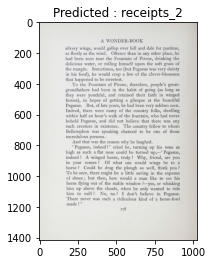

In [ ]:
predict_url('https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Wonder_Book.djvu/page266-1024px-Wonder_Book.djvu.jpg')

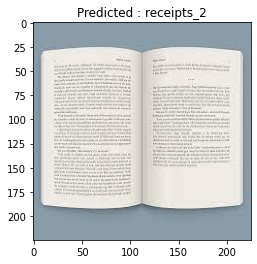

In [ ]:
predict_url('data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBYUFBgVFhUZGBgZHBYaGRkcHBwdHBolGBoaGRkeGhgcIC4lHB4rIR4cJjgmKy80NTU1HCQ7QDs0Py43NTEBDAwMEA8PGBESHDEjISExNzExNDE0MUAxNDFAPDcxMTE/MT8xNDE/MTExQDQxMT80PzQxMTQ0NDExMTExMT8xMf/AABEIAOEA4QMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAAABAECAwYFB//EAEEQAAEDAgMEBgcFCAICAwAAAAEAAhEDIRIxQQQyUWETInGBkbFCUnKhwdHwBQYUI7IzQ1NigpKi0uHxFWNzwuL/xAAXAQEBAQEAAAAAAAAAAAAAAAAAAwEC/8QAGxEBAAIDAQEAAAAAAAAAAAAAAAECERJBA1H/2gAMAwEAAhEDEQA/APTQhCsgEIQgEIQgEIQgEIQgEIQgEIQgEIQgEIQgEIQgEIQgEIQgEIQgEIQgEIQgEITmy/ZlWo3ExvVvckDLvlJnBEZJoXsN+7tU5uYO8nyat2fdl2tUDsaT8Qudq/XWsvAQulb92ma1HHsAHzWrfu5SGbnnvb8GrN4brLlULrx9gUPVcf6j8FYfYdD1P83/AOybwaS45C7H/wAJQ/h/5P8A9lB+w6Hqf5P/ANk3hukuPQuud9gUTo4djj8Vg/7uM0e8duE/AJvDNJcwhe5W+7rxuvae0FvlK83aPs+ozeYY4i492S6i0SyazBVC2obK9+60xxyHiV6FH7Ced57W9gLvkk2iGRWZeShdHT+7rPSe89kDzBTTfsCiNHHtd8oXO8OtJckhdgPsOh6n+T/9lP8A4Sh/D/yf/sm8N0lxyF2J+w6Hqf5v/wBlU/YFD1XD+p3xKbwzSXIIXVu+7tI6vHY4fFqyd92maPeO0A/JN4NZcyhe+/7snSqO9kf/AGWL/u5VGTqZ73D4Ldqs1l4yE/tH2PWY0uLAWi5IcD7s0guonLJjAQhCMVebLvNgaAwAWAgDwC4Grku/2LcH1oFP04rTpglCpWIDZIkCDAEmxEGNYN+5ZnaP5Hn+lSUboWDqztGHei5AteXDj2c0dK+dyBNzibYcUG6Eq6s+bNZHN8cL5G2fggVnmdwGBAxk3zMmMovKBoqEs+s8a04tMvPKdO33KHVnjRhMevF4vaDZAxUeGtLjMDgCT4BYN25h9McbyLSBN9JIE5Kzaj53BGpxg2jsUGq71DEaFpve0dkeKCRVa7dcD2GUrtC3Y5pJhhaYuS2JvliGfYsNoQLbHut7G+Sa6Vrd5wb2kDLPNKbHut9lvkmXuEtlhdnBDZjLM6T8EG34xgMF4nvPhGacaZAPFKMrOmBTMXvLRllAm8q5qv8AUHe8cezhPgg3VglHVniJDANSX8iTp8VIrOjNk2nrHOOtplJCBpCU6d9v2d59PiAWwYvMOPdqrio+3Uad6QHdmEgwgYQlm1nn932kOaRlbxt4qTXcDem/tGE+R+oPeDCAUv8AibSWPGfokmw4Ba0nAyQCL3kR5oK7Runu81wdUQ9wGQc4DuJXe19093muBrb7/bf+oqtEroQhComzq5Lv9i3B3eQXAVcl3+xbg+tAp+nFadaV9072h6sYrEG0pM0z6jyL3LwDcl1+tl84yTtRxDSWiToJie/RJVGXccDAXWcS8xpmByjgpO1XbMSATSuRq8wJs4WN7Se5FSkM8FPOOs86gRJjM3HZxyRgDbtbRBItLjN2xwyyHYgNEQ3oOFhPWJwssOVkEsYCSC2iRAGc2yaCCMt3xVerN+guMJiJMwDzjRWFZgmH0wJABa3+ZsXuDoLa9iGVw4gB9OTi9A5iQDnlOHt70FW02D+BJ0OuLlzB75WtNjDZ/Rl95gDsvqMyFm2rij8xhkgAYONgLnOY8FH4lhM46cEasM7pJm4i94OgPagYNCkbYWe7UE+8EnvUnZGHTPg4ibcjw8ku2oCQ4vokHIxExIsT9WVWMGIECib9WLGZDhBA0Bce8cUabFANMguyAgkkWyz1S20K2ztvIaAMDR1Xlwv1iI7XZ8IyVdoQK7Fut9lvkt6zCYgONiIa7CDJaDJnhfuKX2Ldb7LfIL0GIMWUTIPR6ek8yDLuEg5+/kmaGytjrMYDwHWyyuRmtWrVAuNlZEYGRwwj5KzdmZ6jf7RxnhxWisEGI2ZkRgZFjGEaCAcuCr+Dp+o2/IDWfMnxWjQ60ubGvVI0GRxWvPlzWiBcbGz1B70HZGREEdjnfPmmEIFzso9Z+npHSYz7VrTZhESTcm5k358FdCDOvunu81wNbff7b/1Fd9X3T3ea4Ktvv9t/6iq0SuqhCFRNnVyXf7FuD60C4Crku/2LcH1oFP04rTq+0jqnd03t2xBukAWjqjoBwAvB0gR3/wDSf2g9U3AyuRizIGWqTNYSSHiOtA6M89eyB48VJ2k1W4oxU4ESAwk2Akdx+AUsrD122IcYYYgE2zzki/zlS95AHXcJxXDLWm5GmY/tVg8w443m4G5cdgi47kGTtoOlQgETIpk6YfMTCu3aLb7jAcdw8Ibppc89UMLnYRiqg3klkZgnrWgcPBVe8uFjWboYaJy7LHnx4oI6czAqOuY/Zm0m1yMrjwR+JIvjd6QHUPEX7r+K1Li5xvVGZjCA0dU2mOdr5gLLGQD+2Nh6N9DIgZ/PtQWdVIt0lxmcG8IaZz7f7uSzfWzdjpxJguYeqSDEmdIz5LcB0xjflM4BGR1w58uSp0/87wer6DtJB01N0ars72lxw9Hdos0Q6xIOIcJmJUbQtKL5J6+KwtgLSL8e8W7FntCBTYt1vst8gm3vILeswSb4jciROHnE+5K7DuN9lvkFtXMYevh3vQxcPCPeguzaTH7RgMkbpPGPSH0OcrRtUmPzRllg43BmVlTrkiz3E2IincAza4jh4LQvcbY6kQBZkXJIxEkdnZE6oxDK5knpCQP5DaZjmd0+KOmJmKjsidzmY7T8kOecpq2x3DON8wLxpHHipa8gZ1c88F7AWiMjOfEFGpdVNgKkOuASwwZgCe/zKDWJJirERIweyDwtJHie1AqnP824NsExNuGeqq97hPXqm+jAdNDhgi0yPijEnaSAD0rbgm7CJBFtdC130FYbUf4jDOVnCTMcTwcoNR0xjeJwgdScwBJMcTPjwVvxEkOxuw9SQWG+IEZ6XE8kFhtJg9ZlsM3NsRgTwk2W2zvLmyS057pJFrG55ylBV6s42mRAlhaJi095b9ZM7I6WyCDfMDD7uKC9fd8PNcFW33+2/wDUV3tfd8PNcDW33+2/9RVaJ3QhCFRNnVyXf7FuD60C4Crku/2LcH1oFP04rTrSsYaT1v6RLu4QZSsOgdereRuiRY3JLefuTW0HqmzjlZph2YyMhIupmCMFQ5yDUHLXF258NFJ20M5/nXMRawBzyyv225IDSZtWyIuW+q7nn8YQ9rpnA+LSekgWtliuUUKAxCWObEQS+b5C2LmfeghrCdKogGJcBOI8j9BQ6mcsNXmcY1sbzJteOxMjZWDQ3tdzjri1PEe5V/CMIi5Bn033tB9K9kGLmGYw1bkCcYAF8xBz1VQwzOGr3vGuEZTnBJ/pPJMDZmAh0XBt1nWMTqeCG7KyDAMH+Z2hnja4RrFrDYRVuGjebbS8HT4qGgzEVuMnDwj4f5Fbt2Vmk/3v5g2xI/CtgAYobYQ93Pge1BlSnEQS89UHrgRfsAus9oTLaIbq421cT5pbaECuw7jfZb5Bb1nEReoM9wA5RnYxr71hsO6z2W+QTNSkHDN1g6wdhmYzPdmglkm35ogETa8e6b5/yoAJE4a0kcW/ykgXztHeVDKZIg03mTq8GINiDNrE5aBW6K24SZJ/aHWIvi1wtsjAaZPo1bAEdYXPDPSdVYMxOLsNUXb6Q55Cch8VUUMiKZJvbpCbQRaTBsY7+Qkey89FlGT72B5ifRz9ZGrBhndq6i7gcwefPyRhMG1WRfMSchAPh71H4e4/KNxB/MM3c4um9xef6oVmUi0yKTpERL8XHRzoGTfHkjA8nMCrcuyi1xlyvb2ShwIBE1tRPVM30tlfPkt21HwZpmQDAxNub6zaUdK/+Gf7m875/UoMWvItNW8C7ZjMTiidQZ5LfZnEtuXE/wAzcJ8APeqis/Wm7TJzToOY18lrTeSJLS08DHwRqK+74Lga2+/23/qK76vu+C4Ktvv9t/6iq0SuqhCFRNnVyX0DY9wfWgXz+rku/wBi3B9aBT9OK061qEgHCAToCYHik3gOOIMYZLXTji4AvYXgj3BO1GyIEaZiRnwXnuIa65pCQRGDM5HtFyO/mpOwKLcO5TmCN8xpIyyUlozLadnEnrGwix7bqOkaTGKkZ0w3mAMpyk+BCjGwjfpTMjq52gAiZxT8oQS1jWmcNIG5BDjM6aWGd/nY6NuYbRjjiOo4R60+HhVz2+tRzA3DIknSbknDn2qRUbF30s2zDdTPvkg/9oAMblgogXEYichHq9qHU2mepStguXWi5JytpHf3hqtmMdGQDPUPAyZBjQ+BUGq2Jx04BcHQyQbDvt8kauGCBalMGesYzwui2X/SqKYsCynkJh59ATItoSpxiJxUyMgcBIkFxdcazBjkVHSiMWOlaG4iwi5E5zAJkGEFtmaATDWC3ovLrWzEcZv2KNoWmzvYbAsLouWx2T7vcs9oQK7Dus9lvkEzUpsdGOMiBJ4xOt7wldh3Wey3yC12lzRhksGe+J9UW7y33ILNpgXLGTHrm517Bd3FaNptmzKfox1iTmRw0E+CyY9sjrUS7svmcr8J71pTrtFw+lpJDYzJyPiI0RiAwEAYKMR1RiOsTeMu7wQ6kJPVowZ1NxiAPvA7x3qC9kHrUZuZw2u6BPG/vVy9g9KkIFpZkQZOuWf0UahtMB27SvJEOIJBAE5c2/RQ2mLdSlYmOtlwi2cly1awvBwGmYGGzZAMD46cIVzs7pnDS/sPG0mUYw6MZ4KUZzjOcEnTm3xKvTJaTgYwHI9fOM9LQSQtHbMbDDTjUFlvRmL8j7kfhnHNtO+ZwXJ0N0Ems+cmEQI6/H4TIW1F5cJMdxkeKXGzO9SlpHUNovbvW+z08LYhoy3RAyE2+tEamvu+C4Gtvv8Abf8AqK76vunu81wNbff7b/1FVoldCEIVE2dXJd/sW4O7yC4Crku/2LcH1oFP04rTrSs6GzJGVwJiSBkk+lm+M2j92Rmb3I5X/wCk5XEtO9pu72YylLEnhVsP5fT5cW/UqTtBqz6bp3dwxJdE5cxyVXVT65iW+geMGZ+oQ/Fcg1puBZvqmDEc/EBSMUkTWzF4EZkGLZa35IA18j0hj/4zwPLv7kdN/wCw2z6h4j5Ed6lrj1TNbjGEcBYwFWXZzWMXiG3iQQYAnj3hBDahiGvd6Lf2cXM3E5fCyhtYm2NwN74Oc6crdy0c88apiTui+kWEaW7VVpM51rzo20lwnLSJvI3UakbRqXuw39AzZo5TmZyzEKpq/wDscbG3Rm8AzpF8LrcxyV2SIvWz1A07RkY96zLpn9vYjh6MceMT4oL7ObxjJEGAWFuRzuOaptCvs7SCf2kRHXIixOUXn4Km0IFNh3Wey3yCbdVDYmbg5Cconzy7UpsO6z2W+QTFUE4Yx67mHkLz2k9xQWa8jq9I61icBPviPoc1fp8iXmCAYwHIyDcZHP3ZqjCQR+2seDSNDOU8vFaNmM63oZgSN48PHuQQ/aIcTj6uZbgMwABAMcj4qznnFhFSMWXUyxXHWyyt4KpeZDvzswcOEcQ6LCYzClrza9UwT6IvEZwBa/uQH4iQ0B5Bi5wG8xFtD/ypZXIxEvJwgyMBEGwnncf5KaDHOnr1BZt3ADQ6ERN762C16B0WqP04HItnTOAR/UUYzdtIa4S8wG9bqGDacU6diz6UgA9I4i/7snJ0fA9symBs7r/mPyj0bZX3c7a8Sj8Of4j/ABbxn1e5BmyoTDek6xMjqaAQQRkLglbbM+WzJOdy3CeOXuUDZzEY35ATIm2u7mtKTMIiXOuTLjJuZ8Eaivu+HmuBrb7/AG3/AKiu+r7vh5rgq2+/23/qKrRK6qEIVE2dXJd/sW4O7yC4Crku/wBi3B3eQU/TitOtajA4FpyPMjnmLhJupSSMBIFhFQ3lwJkTzOfCE3XeWtJBaCNXWHeUm9wJBikXSXE4vV3TMSTbuhSdrPY6R1H5HKpfzVG0nFpljwYJH5s4pABGKeAGfNDacEHBTkE3Dzac9M8h9Qh1IGAWMwzAOMi1wIHYRrqgYbWfA/Ldz6zLc876eKltZ5/dkdpbxHCePuPKcRQFxgGG9w83NwBy/wCeSg0puWQDvO6Q5OILo7YBQbOrP/huNpzbnJsZPCD3qWVXExgIHElsaaAkrB1KMmC8yMZ0wxeeA93NUFOLYG3IxfmE+eVwBCNekqi6RNEZYGQJwy83vaR2ElVfTFhhpwOLza7sVvrMoHXlJbQr0WjESOjygFplxDThE8hEdqptCBTYd1nst8gm3TYBsgyDeISmw7rPZb5BbbQB1TDJExjJEEQREDiB7kFmU3XOB4Nhap/+rZlbFjgbMqEZTjHrOMxivn4EC+SXFIRAZTcABHXIvF7QYE6StzTBghjTMkQ83kyY4i5QDGOA3Kk2tjB4NuZ4X7lGEjD1KsiYGIXiCMRnXLs70M2aSAacDq4jjJymIvxUM2fqyadyC09cwQ7O5OXzRjQ0yDGGodAcQgwSQTeZ7tUBhAPUeZzl4JETBEmyg0BE9HYNaQcZ0zE6AXUCjA/ZgGRYvOTiJOecgIJbSOeGpl/Evxix4271DaTo3Kgyt0vFpm4daLd7pU9CAdxsdYAl5vMD3yoFFsiWMAsT1zbKba637EFm0y4YSx2Ehs9fjyByTGzCxluEkkkYsWfP4aQkzSF5bR0iXE5GDNrW4apzZhDY6tid2Y5+9Bavu+HmuCrb7/bf+orva+74ea4Ktvv9t/6iq0TuqhCFRNnVyXf7FuD60C4Crku/2LcH1oFP04rTrSvum4GVyMQzGY1SJqNgjGydOoRpBkGeI7k7tBOEwSDa4GI5iYbraUqHujfeMxJZ7JmIyvHjwUnage28mlab4YiZLZnIC30VDSwBo/J45QM8NrZyI7lodon0z2GmdIB8TJ71XpbT0jSBEzTM2wTEHXEDl6XJBDabJ3aJAByzgXbaMhH1koDWWJbRIzJkzkCYt64meEaqzawkAPpycI3DcnM2OsGO/NQ7aWEb9K9rtOcSZBPIoJdT4tpSSyBiN4lom2cQAqhosQKOQmCfWgQAMr+JUvrtzx0s88JO60vfrbKZ8yo6RoJOOnEvDerfPKxveJ4o0ENvahMWnO0GTPAFx+ihrm4s6NyRZskkyc9b/FWFaRIey2cMJnrQYE5aa8UCtGbyQcTbMIMwDMjtCMTsz8R32O6os1hbEnOSeOirtCvQeS4yXm3pMwjOLWzt71TaEaU2HdZ7LfIJp9MuiC202c3FMxzsldh3Wey3yC9BiCjNmM7tM5+jeT9FX/DOjcpzca2BiYtxxW7Ew1aoPPGymNynPWjegSByykCeXYpbshBkMpgicN3WtbTjHic9XVYIEHbKT+7p2mJLuOL1fW8udmG7IzPA2TnbnK3Qgx/CM9Rn9o+SkbOyZwNn2R8uQ8FqhBn0DPUb4BXAjJShBnX3fDzXA1t9/tv/AFFd9X3fBcDW33+2/wDUVWiV0IQhUTZ1cl3+xbg7vILgKuS7/YtwfWgU/TitOtNoHVNicjDSAbEGxNkqQ4aVbc23xFxJ5x5EJqu0FpBEgxIJjXilBTJzYQYnq1DfCIECRnAF/wDlSdpa8gi9WwkywGYOVm59ikVCM31OqSTLM4gR1Rebm3HsUYCBGCp3PBiLjN2aqXRpW3jAsSZAt2ILMqn+I4wNWETJgZgSQoG0WJ6T0W5sOZkzGu66QjpCDnW4XZMXicvoHwOkJviqDIRg4jDo3iCZmL9iAdWt+0uQcJwGxxZ+Fo5FVftB0qkaQKZJnD87qekdI69Q3d6AA7ScP1PKwahOLrVY6pEMg2EkCRebTblxQW6Qk2e/1h1Mrjq/XNVdJk4q1nWAaBnOUiS0fJToB+cbETqYdF+Zz7FDaZkdWoYB3nwLAACAdfnxRq1AGTZ+W88tvygdnvWe0K9BkE9WDFzjLzoLz2R/SqbQgU2HdZ7LfIL0GJDYd1nst8gn2IN2LZYsWyCqsFVWCAQhCAQhCAQhCDOvu+C4Ktvv9t/6iu9r7vguBrb7/bf+oqtEroQhComzq5Lv9i3B9aBcE8L39g+8rGMDajX4hq0AtPA5yDyhcXiZUpMQ6VzQRBAI4FYjZWDJjRpYLzWfebZjm8t7WP8AMNhMM+3NmP79necP6oU8SpmDQ2Vmce93COPBA2VsR1tDdzjlwkqrPtGi7dq0z2PafIrZlRpycD2EFcjH8Lwe/S+KciDacsvegbLYjG+4I3haSDItnb3lMwiFrS7tm/nqdkjhHDv7VU7KCCC95nD6XqmRHDmmiFELBh+FEyS467xzgtmOMFVbsjAIgm4N3OOQgZngmTbOyXq7bTZvVGN7XtHmUYG0GM3Wgdg7T8SltoS+0/ePZmfvmu9gOf72gheHtn3tabU6T3c3kNHgJJ9y2KyzaHtbDus9lvkE+xcbsX3mwANqUnWAGJhBytuuiPFe3sv3j2Z37zCeD2ub7yI96TWTaHvMWyR2f7QpP3arHdj2nyKdaZFr9ixqFYKIUgI0IRCIQCFVzwMyB2mFg/bqTd6qwdr2jzKMMoXnv+2tmH79nc4HyS7/ALy7MP3k9jHn34YXWJMw9Svu+C4Ktvv9t/6ivf2n7z0y0hjXudpIhveZmO5c6CSSTmSSe+5VKRMJ2mJShCF2mFBbKlCDJ1ELN2zhMoQJu2UcFQ7IOAT0IhAi3Zoyt2Kwa8ZPd/cfmm8KjCmG5K9f13/3O+ahzHHNzj/Ufmm8KMKzBl552QHMKzdkHBPYVOFbgyTbso4LdlABbAKUYxqUQUu7ZRwTyghAg7ZRwVPwg4L0cKjCmG5JtpuGTnDsJVhj9d/9zvmmsKMKzBkqWvPpv/uPzUOoTmSe0pvCpwrcGSQ2QcArN2UcE5CIRhduzhaNohawhBVrAFZCEAhCEAhCEAhCEAhCEAhCEAhCEAhCEAhCEAhCEAhCEAhCEAhCEAhCEAhCEAhCEAhCEAhCEAhCEAhCEAhCEAhCEAhCEAhCEAhCEAhCEAhCEAhCEAhCEAhCEAhCEAhCEH//2Q==')

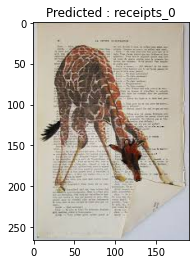

In [ ]:
predict_url('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQcPd0S_2dnkekEWhc02yQ59E2BTZttXViiZQ&usqp=CAU')

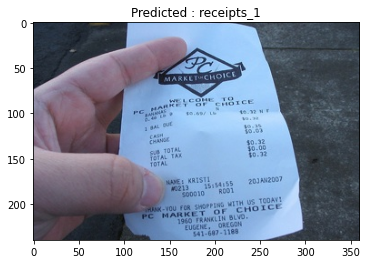

In [ ]:
predict_url('https://cdn1.matadornetwork.com/blogs/1/2011/04/feature-39361.jpg')

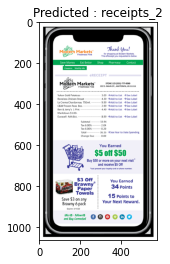

In [ ]:
predict_url('https://www.ecrebo.com/hubfs/Ecrebo%20New%20Site%20Files%202020/Images/OnPoint%20Receipts/OnPoint-Digiotal-Receipts-1.png')

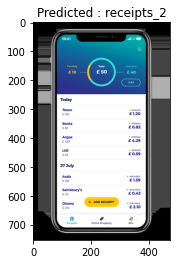

In [ ]:
predict_url('https://zipzero.com/assets/images/app-screens/dashboard.png')

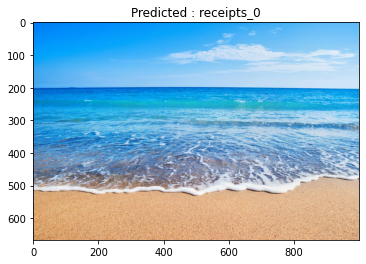

In [ ]:
predict_url('https://cdn.mos.cms.futurecdn.net/wtqqnkYDYi2ifsWZVW2MT4-1200-80.jpg')

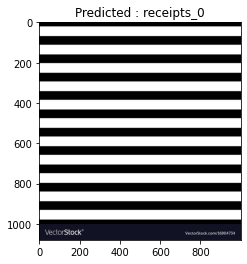

In [ ]:
predict_url('https://cdn5.vectorstock.com/i/1000x1000/47/34/horizontal-stripes-seamless-pattern-vector-16904734.jpg')

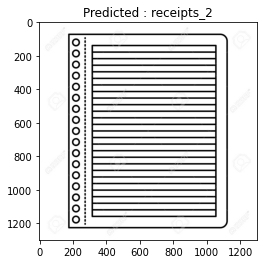

In [ ]:
predict_url('https://previews.123rf.com/images/grgroup/grgroup1802/grgroup180200368/94791758-notebook-paper-with-horizontal-lines-in-black-contour-vector-illustration.jpg')

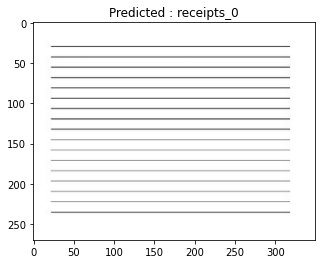

In [ ]:
predict_url('https://ecdn.teacherspayteachers.com/thumbitem/horizontal-lined-paper-3552989-1514414389/original-3552989-1.jpg')

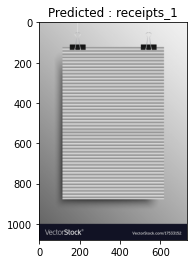

In [ ]:
predict_url('https://cdn3.vectorstock.com/i/1000x1000/31/52/pattern-paper-horizontal-lines-grey-galousie-vector-17533152.jpg')

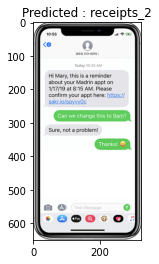

In [ ]:
predict_url('https://sakari.io/wp-content/uploads/hero-phone-single-v1.1-1.png')

# **Using Google Cloud Vision for reading text from picture**

## Loading best_model to predict

In [31]:
!pip install google-cloud-vision

     |████████████████████████████████| 471kB 7.2MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 


In [32]:
import os, io
from google.cloud import vision
from google.cloud.vision_v1 import types
import pandas as pd

In [33]:
!export GOOGLE_APPLICATION_CREDENTIALS="ServiceAccountGoogleToken.json"

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r'ServiceAccountGoogleToken.json'

client = vision.ImageAnnotatorClient()

print(client)

In [26]:
import urllib.request

def detectText_from_url(url):
    with urllib.request.urlopen(url) as response:
        html = response.read()

    image = types.Image(content = html)
    response = client.text_detection(image = image)
    texts = response.text_annotations
    
    df = pd.DataFrame(columns = ['locale','description'])
    
    texts = response.text_annotations

    for text in texts:
        df = df.append(
            dict(
                 locale = text.locale,
                 description = text.description
            ),
            ignore_index = True
        )
    return df['description'][0]

In [27]:
def detectText_direct_img(img):
    with io.open(img, 'rb') as image_file:
        content = image_file.read()
        
    image = types.Image(content = content)
    response = client.text_detection(image = image)
    texts = response.text_annotations
    
    df = pd.DataFrame(columns = ['locale','description'])
    
    texts = response.text_annotations

    for text in texts:
        df = df.append(
            dict(
                 locale = text.locale,
                 description = text.description
            ),
            ignore_index = True
        )
    return df['description'][0]

In [ ]:
text = detectText_from_url('data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBESERERERERERERERIREREPERIRERIQGBQZGRgYGBgcIy4lHR4rHxgYJjgmKy8xNTU4HCU7QDs0Py40NTEBDAwMDw8QEBERHjcdFh00NDQxMT8xMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMf/AABEIAOEA4QMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAACAwABBAUGB//EAEIQAAICAQIDBQYCBwYEBwAAAAECABEDEiEEIjEFE0FRYSMycYGRsRRyBjNCUqGywWJzgrO00TRjdIMVJCVTVHXw/8QAFQEBAQAAAAAAAAAAAAAAAAAAAAH/xAAVEQEBAAAAAAAAAAAAAAAAAAAAEf/aAAwDAQACEQMRAD8A9UqxqrIqxirApVjVWRVjFWBQWGFlhYwLAELDCwkXcfETX3Q326wMYWEFmsYR5S+6HlAyhZemahhEIYR5QMmmTTNnciQYh5QMemTTNowjy6y+5XbbpAwaYJWdIYF326y/w67bdIHLKwSs6/4dbJrrt6SfhUqq8bvx+sDjFYJWd38KmrVpHSq8PpB/BJpK1sTd3zfWBwSsArN3aCBcmlQAAi7D4mZSsDOyxbLNLLFssDOyxTLNLLFssBGmSM0yQHqsYokVYxVgRVjFWRVjVWBSrDCy1EMLAiruPjNoWZUXcfETeqwKVYQSEqwwICwkuh6efyjKnmOK7Kytm41kwjTn4fKmvIcRZshRVQY2B1KhA3VtgQCIHo9IkFVdivO9p5rJ2LxGjiVZjl7xeCoOca94uJy2TEdIAAK8tnrqgP2HkfGyDEmFH45cy4HGPImHEMWhiVB0m2BbSD+18YHqak2+nWcntDsnVwScIup1X8PjYuwDNjTImok+elSZzP8Awni3xZsORUY5uKx68jsCuThceJF1sqkG37sKV/tHwgepkseY+s8rn7N4wjhHVVPEcNgyYS5dQGLOmPV16FQXrzUDrAHYmRE4JBi1pw+TiSwB4dyFbLeNqybe6LJHMPjA9fJKLStUA7kuK1yd5A5XaB/8wR/y0/maJZYfGNfE/wDbX7tLZYGdli2WaWWKZYGdli2WaGEWywE6ZIVSQNCiMUQVEaogEohqJSiMUQLUQgJFEYBAijcfGbRMjDb5j7zXAIGFcAS7gYh2dWmsj8uoi/3mBs7V1LE/7Ql4GgoGRwFBFWwB5Ao6Hwq/mfjNdyiYGLG6ozK2RrJVBqFAsVHu7+NX85XDY1bcZSdIQEAFRtVbX/Z+/wABrfGp3Kgm7ut7qvtFJiRCSqgEkkkQMmNVUK3eZW0Jrs6t1Vzdgnr4EeUHKBrbnddRZAAp2ezkPjXQivhv5TW+NCKKqR5Eet/feLOJP3R1LdP2j1PxgZHy42G+bJvpZa1AjvKCDY7kVfzmzPj1lSWXlDj3LBLCr62Nr2ijhx/uJ4D3R4bj6Qi0AWwLoVdR5UKAkA7FQPpyg1GY30qq37oAv4CKLQSYDzmgHNEEwCYC3e+IB/5YH8TNbCYE/Xr+X/edEiAlhFsI9hFsICGEWwj2EUwgK0yQqkgPURiiCojVEC1EYolKIxRAtRGASlENRAFxt8x9xNMz5fd+a/cTQYCX4e9fPkGsAcrVoodU8jLbDZY63GpAlBtl68w8m36xtyXAUuGip1vypootsenMf7W3WAMQQIS71jUgl32YV1c+M0RHFYi6gAgEMjDULW1awCNrG0Ba41AQ94xCE5NRyA6la/ePiu5r4Qe6UgVkcg5NYIe7vmC3+76eUVk4As7OXBLoEKlaTSKIqiGFMCeviZE4GmR2dmZShJ3AYqjJut1fNdwJkRPaA5WHOrtzgHH0of2Qa6esHMqHXeUrrQHZwNCjbUvl16wM/Z2psjB6LlTuDS06NtRBF6N/l5bzJwRIddS0+lr0tqDqEHvarrk+O/WATqps94RrQYxTgCzZBX+0bgoqkgq5bQndkBwwvbdgP2tusB+zwx5zY1WyixfswlXd14x+PHpLn99y/SuoA/pAUmCu753OhSvM1678W8zBHD1o53Ohi27e9d7N5jfp6TSYJgZjw+1a3/Wa71b9b0/l9IZhmCYGZB7dfh/vOownOxj26/l/3nUYQEMIthHsIthAzsIthHsIthAVUkKpIDVEaogKI1RAJRGKIKiMUQLURgEpRDUQF8R7vzX+YR8RxXuf4l/mEfAxBsT95pzHnIRtOStDKDsnkdj9ITHGSzd77+NV2yCgDdMovqd9/GpgOHhbU92zNrdxTliHBaxu3xNdBY6WJMacNjAC4slIxWrJAZEKXRb91iPkPSBu7zENLd77qHHRydeXVZHUvpUnz6y0VAcY7wkpaAHICXahsw/aYRCdjYBr5SdZJNu2w0MmkUeml2Hzhr2ZhDahj3195epjT6laxv5qDX+8Bq8MAEGtzoZmFuSWu9m8xv0+Eo8MKrW/v671m7u9P5fSPMEwM78MDrGvINbh9nI0kVsvkNunqYOThwdfNkGsAHS5Gmh+z5TQZRgZ3wAljqfmTRsxoDfceTb9YPciwdT8qFKLGiNtz5tt1jzBMDOnDhdHM57tSo1OTqvxbzMQ4RCiNkYNqd1D5Db7EkHzAvpNpmfiOEx5DboGOh0s+COAGA8rA6wEUlV3p2c5LOSuhBIv9zcem80GYuI4TCRlLY7NUQHI1gBX2HpX8PWblQAADYAAAeggK4dfbD0WdJhMnCp7QnyQfebWEBTCLYRzCLYQEsIphHsIphAXUqFUuAxRGrFrGLAYsNRBWGsA1EYsFYYgI433B+dP5hHRHaHur+dP5hHwMSvns+4VBAuxvzC9/QE+HgJYPEEqfZgbah1sV4G/P7zP3eMCy7qCzMCQAGCnc7eG9WdzdQsLYUYHvGJJAUNY3awNq67EelekDo3KnPxtiQq2trHu6lO4YORW3kT9B5wceHHae0yM1grdg2Sz9K28fpA6JlGI4bhRj6MzcqqSxs7Fj1/xGOMATKMIyjAAwTDMowFkSiIdSiIGLIX9pXoE58Yrbrv069D5es0AbC/nMmY4/bkuRSqMlAbCjQHr1mxANIrpQr4VAbwa8zH0AmhhFcIN2+Uc0BbRbRjQGgKaJaOaLaAuSXJAYsYsWsYsBqw1gLGLANYwQFhiBm7RPKn51+8eZm7SOyfnX7zQYHNZ3/8AjrevIRag8pGx28T43XSEuUk6hgGzlbreg4GoberHy67zS7ZOfSiGgO7tyNRrfVty/wAZbNktqVSAgKEsbL77HbYdN4GVWIo9wAAAelaRZB8PC/vBx5iUx5MeFdTq9kfsFQQoO2/l9ZrVntbVa0WxDGw+3KNtx13lI2T2epEFg95Tk6WrYLtuL+EC8Ds2rUumjt13G8MxSvkpLRASzB6cnSm9Ebbnpt8ZWvJXuJfeVWs13d+9096vCA0yjFM2TnpEJDgJbkak2snbY+9t6CU7ZPaaUQ0B3duRqat9W238YDZRi3Z7alUgJaW5BL77HbYdN5QOS1tVrRbHUbD7bAVuOu8BkqotDk5NSILU95pcnS3gF23HWCrZKS0QEsQ9OTpTeiNtz02+MBGTV7TkUnbSdDEMK3B8z19Nx6zSo2G1bDby9JWrJXuJeuq1mu7v3unvV4RtQGcMN2+Ua0Vw3VvlHNAU0BoxotoCmimjWi2gLklyQDWMWLWMWA1YxYtYawGrDEBYYgYu0zvj/OPuJqMxdqHmx/mH3E2mBwm7QzY/xTOyOuPPjwpqTukVXXGxd3F8o1kXXhKXtxt3dFRPwmPiQrF+81szAiq90UtnwsE9dugWzbBQCbyaixSgK5dIBG1kdd47h+8tu8qjRWuo62CfHw+sDn9m9pPmfGSuhXwZHKe9Tpm0bN5UCfnOtJcqBDKMsyoAyS5IFSSSQKqcPju0c+McR+r5M2FEbTS48brZZiTRPr0szuwcurS2kEtR0gEA38TtA4vaPabLw2PLjZVb2bZFyBRkCtjL6AhNaztS/GdlDYB33ANEUdx4iZvbU+9nko3jBH73oDXn4+k1oDQutVC66XW8A8A3b5RjQMXVvlCMAGi2htAaApotoxotoASSSQCWMWKUxqwGrGKYpYxYDQYYi1MNTA5/ah58f5h9xNxnO7TPtMfxH3E6JgYjwQ2piCuvSygAjWQTfn08YD8AaULkawUsuSQyqBtt8P4mWz4H7y22clMlsy2UXcDyoeUK8THI2r9gI51MAEqx8Op36/SA/h8WhdOpm3JtzZ3MZcx+yBHMAUQ46LNstAkEefTeFgxJpxsgNInISze6wHW+u3nA0yjEpwqAIADyMXXmY0xu7336nrJ+FSqo1r7z3m9+7vr0vw6QHSRLcKhDgg87h25mHMKqt9ug2lvwqNrsH2gAemYWB0rfb5QG1JUW3DISxINundtzN7m/06neQYEBU+Kp3Y5j7hrar67DeA2pIpOGxrorrjBVOcmgdiDvv08ZE4bGNAH7DM685NMbu99+p2MAH4QMcm/v6QRXTT08etmaFWgB1oVZ6mYycIBB1AB3zb95etG5v4+E3Lvv5wInU/KW0odT8pTQBaLaExgMYC2i2hsYtoA3JKkgWpjVMQpjVMBymNUxCmNUwGqYamKUwwYHN7RPtU+K/cTpmcjjz7ZPiv3E65gch8mMEluHNg5WGxsoALb5g/LeOV1/9kjWQrbHf1O3T1Pr0mjK7jvKQNpA7vnA7wkbj0lPlcFqSwEtTqHM+/L6eG/rAy43QtQwsuvmcsrDq1Gz57Axq8SVAAxtQLqFQNaquwG/Ukb+VQhme1BSgU1MdQ5X25fXx39JEzudF461AnJzg92a2Hr8oE4Ximc0yMm12b0nmIAF79ADNMzJnc6Lx1bEONYOhRdH1uht6yd+9fq99emtY9y/f+nhA1CXMrZnp6x2Q4CjWBqQ1belWdvSE+Vx3lY9WkDRzgazW49IGmVoHWhfnQ//AHgPpEtke2pLATUp1Aan35fTw39Zau9qNFApqY6hyvty+vjv6QKzZCroq49WrWS/QIQLFmvExR4kjpjF+zsaWBBf3h03q+sfjyOdGpNOpSX5we7bwHrLTI5CXjq2IcawdCb03rdDb1gYCwqvw2wVwFYM1DXW4O1Vv9Z1U6ChQoUKqhXSooZHr3N9emtY9y/f+m9TQICz1PwEFjLc8x+A/rAYwKYxTGGximMAWMUxhsYpjAq5cG5UAlMYpiFMYpgaFMNTEqYamA9TDBiVMYpgcrjW9uv5k+4nXdpxOJb24/Ov3E7OSAt3iWeXkiSIFnJLGSZOK4pMY1ZG0jS7WQTyoupjt5CZOI7e4TGqNkyhRkRXQlX3RgSp2HoYGviuLyo/IgddAagG1F9arV3XQk/KZz2rm6Dh2vumYag+nvtTaUJHhpWyfUSHtvhQ2NTlGrKQEGl+YmgPD1EofpDwnd993y93r7vXpetenVXS+m8B/DdpZXfGrYWRHGTU7K3IVd1Cn1IUG+n1EvP2jnQOe6B05HRaGR9YVCy9BY1bKD0Bu72l5e2OGxsivkCtkZUQaW5mYKQOnk6/WXxfbvC4f1mUJuRurncEg9B5qfpAbi47I2Qp3dBcmhmIcbanAIPQ8qIdtuadMGchO3+ELaBmGqga0v0ILDw8gYzJ27wiBC2UAPq0cr81Irnw/dZT84HUBhiYuG7Qw5HKY3DOLJFMOiox6jyyIf8AFNogEIQgiGIGfIec/lX+sBjLynnP5V/rFsYFMYDGRjAYwBYxbGWxi2MCXJAuSBFMapmdTGKYGhTGKYhTDUwHqYxTEKYYaBycze3/AMa/cTvZBPOu3th+df5hPSOsDI4iyI91gFIHm/0qHsz/AHPF/wCSZ4r9JP1PB/8AS8N/I8+ocTwuPIKdFcUy0wsaWFMPmNpmzdicLkCq/D4nCKqIGSwqKCFA9BZgeA4ge37O/vMX8yTCR/6Wf/sD/p59RPY3CkoxwYy2MgoSu6EdK8uglDsHhNHdfhsXd6+80aOXXp06q862geM7d/4jgv8AqsH+Vw0zfpr1H53/AJ8s+h5OyeHcoz4UZkYOhZbKsAoBHqAi/QScT2NwuX9Zgx5N751veyfux+sD5xwv/FH8mL/JeP7V9zgv+9/pcE+gr2LwgbWOHxBqA1Bd6AofwJhv2PwraA2DG3d3otb02oU18lUfKBwf0Z/4vJ+V/wDT8FPXiZcHBYsbF0xojGwWUUTYRfsiD/CJpgHcsGLuXqgIzHnP5V/rFMZeY85/Kv8AWLYwIximMtjAYwKYxTGWxi2MCXJAuSBSmMVpnVo1WgaFMYrTOrRitAerRgaIVoQaByUPtl/vF/mE9U2ZNTLrXUothYtR6zlDCnXSL+EYqL5D6QND5sekNrXSxoG9iZRZbK2NQFkeNRYVfIfSEAPIQKLpWrUKur9ZYIvTYsiwPSEAPIfSFt5CAAdaJsUNifWGGWwLFnp6ybeUvbygQOu+45evpC7xeXcc3u+sAkDrQHrQEs15QC1ruLHL73pJ3qUDqFNsPWAa8oJryEB3eLZFiwLI8hB79KDahpJoHwuKNeUEgeQgPOVdWnUNVXV71APFJpLa10g0Te1+USQPIQCB5D6QDyNbk+BVf6xbNKJgs0CMYtmkZotmgUxi2MtmimMC9UkDVJApWhq0zq0arQNCtDVpnVoxWgaFaMDTOrQlaBoDQw0QGhBoDw0INEBoQaBy1ycdruhpOkHUMZCsCb0gNulHqSG2HrAbi+MXTaHU5CqAivbalBLUaRdJY7eXkDOwGhapUjmNk44MRWNlA2YKltsdW2oUw20+B8fMW7cWq4ypOrTk1l1xso9ralwGvZL929wBOlql6oV539IcPF8RwaMi5A7hjk4bG6430OpKDU37SHQSLF0wgpwnaA4bh9LuM6Pmyuj5O8s92/dI7a+YBtAIuvGek1StUVI89kz9rh2ATA6DKFD6FBbHzU1axsRpvoQbq5jXN2rlGDKuPTWl2ViMWpWVdQbGHpqttOqjYGrTvPWapRaKQYbYf16yi0AtALSKMtALSi0AtAJmgFoJaCWgRmgM0pmi2aBGaLZpGaLZoBapIvVJAixiySQGLDWSSAwQ1lSQGCEJJIBCEJckCCWJJIFiSSSBJJJIFGSSSAJgmSSAJgGXJABoDSSQFtAMkkBbRbSSQAkkkgf/2Q==')

In [ ]:
words = []
words.append(text.split())

In [ ]:
if 'SHOP' in words[0]:
  print(words)

[['SHOP', 'NAME', 'adres', 'Lorem', 'ioun', '231', 'Te', '11', '...', 'CASH', 'RECEIPT', '...', 'Descriation', 'Lorem', 'Price', '22', 'baleran', 'amet', 'Consectetar', 'Adipineng', 't', '44', 'Total', '16.5', 'Ca', '20.0', 'Change', '..', 'ak', 'and', 'Aper', 'Code', '234', 'THANK', 'YOU', 'ur', 'designed', 'by', 'd', 'freepik']]


In [ ]:
detectText_direct_img('1003-receipt.jpg')

'El Gran Mar de Plata\n10325 Hammocks Blvd\nMiami, FL 33176\n(305) 386-6638\nServer: Kayra\nStat ion: 10\nOrder #: 8262\nDine In\nBar Tab: Bar Tab\n» SETTLED «\n1 Miller Lite\n5.00\nSUB TOTAL:\nSales Tax:\n5.00\n0.35\nTOTAL:\n$5.35\nCash Tendered:\n5.35\nBalance:\n$0.00\n» Ticket #: 35 «\nCreated: 4/20/2017 10:13:17 PM\nSETTLED: 4/20/2017 10:13:25 PM\nTHANK YOU!\nwly do I alenys get\nshort Changed I\ngue\nyeu\n'